In [2]:
import numpy as np
import pandas as pd
import scipy, scipy.signal

from datetime import date
import time

from random import seed
from random import random

import os, os.path
import shutil

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import matplotlib
import matplotlib.pyplot as plt
from pylab import imshow

import h5py
import sys
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/NASA/Python_codes/')
import NASA_core as nc
# import NASA_plot_core.py as rcp

# Do the digits to make sure things work

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()

In [3]:
# Print to show there are 1797 images (8 by 8 images for a dimensionality of 64)
print("Image Data Shape" , digits.data.shape)
# Print to show there are 1797 labels (integers from 0–9)
print("Label Data Shape", digits.target.shape)

Image Data Shape (1797, 64)
Label Data Shape (1797,)


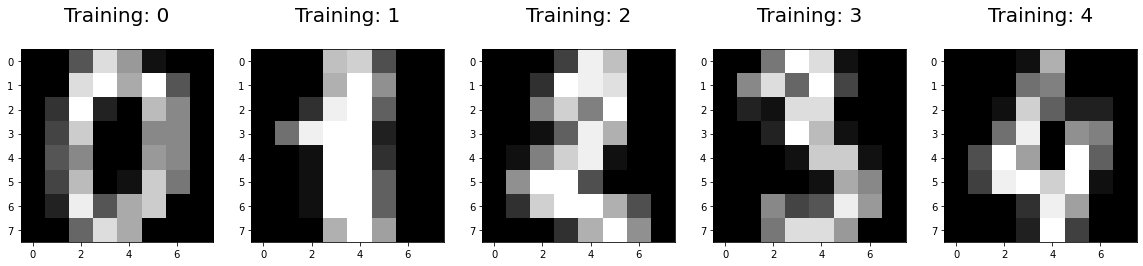

In [4]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(digits.data[0:5], digits.target[0:5])):
    plt.subplot(1, 5, index + 1) # 1 row, 5 columns, 
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)

# Split dataset

In [5]:
# split the train and test set randomly
x_train, x_test, y_train, y_test = train_test_split(digits.data, digits.target, 
                                                    test_size=0.25, 
                                                    random_state=0, 
                                                    shuffle=True,
                                                    stratify=digits.target)

In [6]:
# Make an instance of the Model
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression(max_iter=100000)
logisticRegr.fit(x_train, y_train)

LogisticRegression(max_iter=100000)

prediction is [2].


Text(0.5, 1.0, 'Actual image of the Test: 2\n')

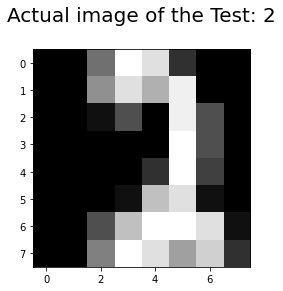

In [7]:
# Returns a NumPy Array
# Predict for One Observation (image)
test_index = 0

prediction = logisticRegr.predict(x_test[test_index].reshape(1,-1))
print ("prediction is {}.".format(prediction))

plt.subplot(1, 1, 1) # 1 row, 5 columns, 
plt.imshow(np.reshape(x_test[0], (8,8)), cmap=plt.cm.gray)
plt.title('Actual image of the Test: %i\n' % y_test[test_index], fontsize = 20)

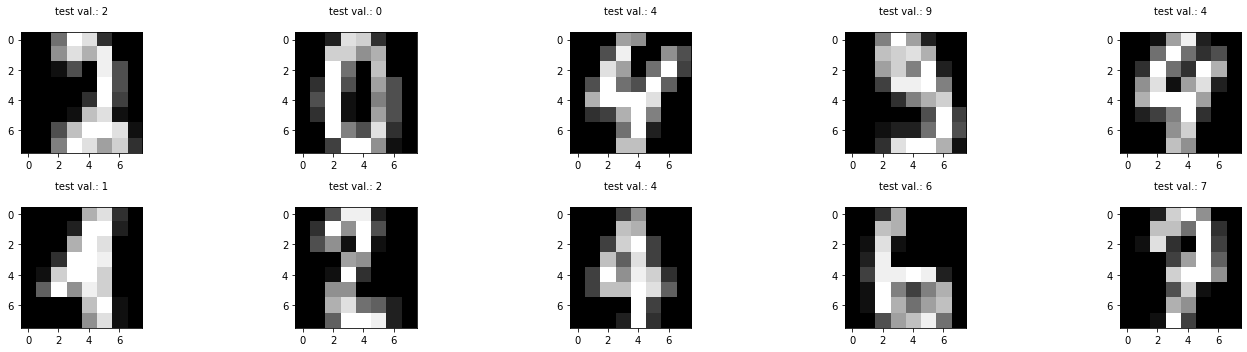

In [8]:
multiple_test_size = 10
logisticRegr.predict(x_test[0:multiple_test_size])

plt.figure(figsize=(20,5))
n_cols = 5
n_rows = -(multiple_test_size // -n_cols)
for index, (image, label) in enumerate(zip(x_test[0:multiple_test_size], y_test[0:multiple_test_size])):
    plt.subplot(n_rows, n_cols, index + 1) # 1 row, 5 columns, 
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title('test val.: %i\n' % label, fontsize = 10)
    
plt.tight_layout()

In [9]:
# plt.figure(figsize=(20,4))
# for i in range(1, 7):
#     plt.subplot(2, 3, i)
#     plt.text(0.5, 0.5, str((2, 3, i)), fontsize=18, ha='center')

# Read Training Set Labels

In [3]:
training_set_dir = "/Users/hn/Documents/01_research_data/NASA/ML_data/"
ground_truth_labels = pd.read_csv(training_set_dir+"train_labels.csv")
print ("Unique Votes: ", ground_truth_labels.Vote.unique())
print (len(ground_truth_labels.ID.unique()))
ground_truth_labels.head(2)

Unique Votes:  [2 1]
434


,ID,Vote
0,99837_WSDA_SF_2017,2
1,114615_WSDA_SF_2017,1


# Start VI images

In [4]:
interval_size=10
no_data = 365//10

In [5]:
idx = "EVI"
data_dir = "/Users/hn/Documents/01_research_data/NASA/VI_TS/05_SG_TS/"

In [6]:
file_names = ["SG_Walla2015_EVI_JFD.csv", "SG_AdamBenton2016_EVI_JFD.csv", 
              "SG_Grant2017_EVI_JFD.csv", "SG_FranklinYakima2018_EVI_JFD.csv"]

data=pd.DataFrame()

for file in file_names:
    curr_file=pd.read_csv(data_dir + file)
    curr_file['human_system_start_time'] = pd.to_datetime(curr_file['human_system_start_time'])
    
    # These data are for 3 years. The middle one is the correct one
    all_years = sorted(curr_file.human_system_start_time.dt.year.unique())
    if len(all_years)==3 or len(all_years)==2:
        proper_year = all_years[1]
    elif len(all_years)==1:
        proper_year = all_years[0]

    curr_file = curr_file[curr_file.human_system_start_time.dt.year==proper_year]
    data=pd.concat([data, curr_file])

data.reset_index(drop=True, inplace=True)
data.head(2)

,ID,human_system_start_time,EVI
0,135073_WSDA_SF_2015,2015-01-10,0.054429
1,135073_WSDA_SF_2015,2015-01-20,0.051731


In [7]:
ground_truth = data[data.ID.isin(list(ground_truth_labels.ID.unique()))].copy()

# Sort the order of time-series and experts' labels identically

In [8]:
ground_truth.sort_values(by=["ID", 'human_system_start_time'], inplace=True)
ground_truth_labels.sort_values(by=["ID"], inplace=True)

ground_truth.reset_index(drop=True, inplace=True)
ground_truth_labels.reset_index(drop=True, inplace=True)

In [9]:
assert (len(ground_truth.ID.unique()) == len(ground_truth_labels.ID.unique()))

In [10]:
print (list(ground_truth.ID)[0])
print (list(ground_truth_labels.ID)[0])
print ("____________________________________")
print (list(ground_truth.ID)[-1])
print (list(ground_truth_labels.ID)[-1])
print ("____________________________________")
print (list(ground_truth.ID.unique())==list(ground_truth_labels.ID.unique()))

100658_WSDA_SF_2017
100658_WSDA_SF_2017
____________________________________
99868_WSDA_SF_2017
99868_WSDA_SF_2017
____________________________________
True


# Convert the dataframe to numpy array 2D

In [11]:
TS_array = np.zeros((len(ground_truth.ID.unique()), 36))
for count, ID in enumerate(ground_truth.ID.unique()):
    TS_array[count] = ground_truth[ground_truth.ID==ID][idx].values[:36]

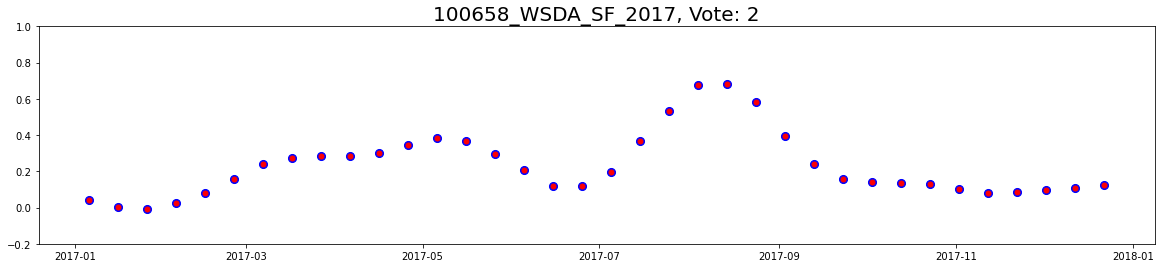

In [13]:
plt.figure(figsize=(20,4))
plt.subplot(1, 1, 1)

field_number = 0
plt.scatter(ground_truth[ground_truth.ID==ground_truth.ID.unique()[field_number]][\
                                                                        "human_system_start_time"].values[:36],
            ground_truth[ground_truth.ID==ground_truth.ID.unique()[field_number]][idx].values[:36],
            marker='o', s=65, c='b', label=idx);

plt.scatter(ground_truth[ground_truth.ID==ground_truth.ID.unique()[field_number]]["human_system_start_time"\
                                                                                 ].values[:36],
            TS_array[0], 
            marker='o', s=25, c='r', label=idx);

plt.ylim([-.2, 1])

vote = str(ground_truth_labels[ground_truth_labels.ID==ground_truth.ID.unique()[field_number]]['Vote'].values[0])
title = ground_truth.ID.unique()[field_number] + ", " + "Vote: " + vote
plt.title(title , fontsize = 20);

# Split Train and Test Set

In [14]:
# split the train and test set randomly
x_train, x_test, y_train, y_test = train_test_split(TS_array, ground_truth_labels.Vote.values, 
                                                    test_size=0.25, 
                                                    random_state=0,
                                                    shuffle=True,
                                                    stratify=ground_truth_labels.Vote.values)

In [15]:
# Make an instance of the Model
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression(max_iter=100000)
logisticRegr.fit(x_train, y_train)

LogisticRegression(max_iter=100000)

prediction is [1].


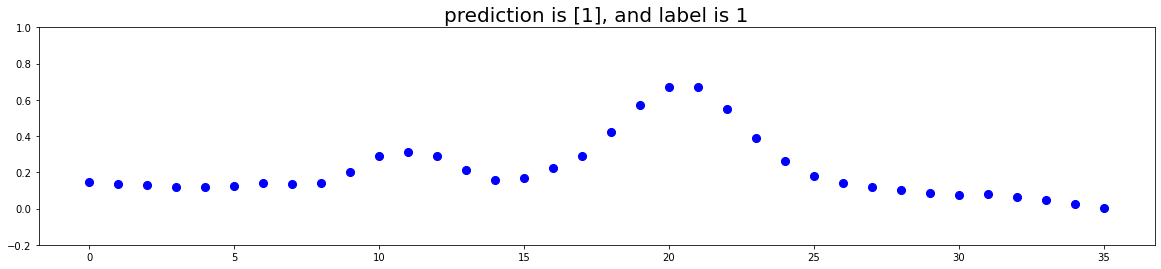

In [17]:
# Returns a NumPy Array
# Predict for One Observation (image)
test_index = 0
prediction = logisticRegr.predict(x_test[test_index].reshape(1,-1))
print ("prediction is {}.".format(prediction))

######################################################
plt.figure(figsize=(20,4))
plt.subplot(1, 1, 1)

field_number = 0
plt.scatter(range(len(x_test[test_index])),
            x_test[test_index],
            marker='o', s=65, c='b', label=idx);

plt.ylim([-.2, 1])

title = "prediction is " + str(prediction) + ", and label is " + str(y_test[test_index])
plt.title(title , fontsize = 20);


In [18]:
y_test[test_index]

1

# Logistic Regression with Pandas

I want to split pandas dataframes so that we have access to IDs easily.

In [19]:
EVI_colnames = [idx + "_" + str(ii) for ii in range(1, 37) ]
columnNames = ["ID"] + EVI_colnames
ground_truth_wide = pd.DataFrame(columns=columnNames, 
                             index=range(len(ground_truth.ID.unique())))
ground_truth_wide["ID"] = ground_truth.ID.unique()

In [20]:
for an_ID in ground_truth.ID.unique():
    curr_df = ground_truth[ground_truth.ID==an_ID]
    
    ground_truth_wide_indx = ground_truth_wide[ground_truth_wide.ID==an_ID].index
    ground_truth_wide.loc[ground_truth_wide_indx, "EVI_1":"EVI_36"] = curr_df.EVI.values[:36]
ground_truth_wide.head(2)

,ID,EVI_1,EVI_2,EVI_3,EVI_4,EVI_5,EVI_6,EVI_7,EVI_8,EVI_9,...,EVI_27,EVI_28,EVI_29,EVI_30,EVI_31,EVI_32,EVI_33,EVI_34,EVI_35,EVI_36
0,100658_WSDA_SF_2017,0.039378,0.003539,-0.008009,0.025816,0.081537,0.156433,0.239957,0.27463,0.282809,...,0.155738,0.138827,0.136556,0.127832,0.09996,0.082512,0.088335,0.095237,0.108741,0.125825
1,100661_WSDA_SF_2017,0.0,0.0,-0.003635,-0.000627,0.008302,0.034272,0.068471,0.109112,0.157214,...,0.131337,0.194901,0.291371,0.365691,0.404244,0.439063,0.458254,0.481119,0.470967,0.445632


In [21]:
ground_truth.head(2)

,ID,human_system_start_time,EVI
0,100658_WSDA_SF_2017,2017-01-06,0.039378
1,100658_WSDA_SF_2017,2017-01-16,0.003539


In [22]:
ground_truth_labels.head(2)

,ID,Vote
0,100658_WSDA_SF_2017,2
1,100661_WSDA_SF_2017,1


# Check if we did the right things:

In [26]:
[ground_truth_wide.ID==ID]

,ID,EVI_1,EVI_2,EVI_3,EVI_4,EVI_5,EVI_6,EVI_7,EVI_8,EVI_9,...,EVI_27,EVI_28,EVI_29,EVI_30,EVI_31,EVI_32,EVI_33,EVI_34,EVI_35,EVI_36
120,107073_WSDA_SF_2018,0.073924,0.088814,0.121649,0.116224,0.125506,0.150642,0.184136,0.218275,0.245131,...,0.231411,0.312705,0.40215,0.486309,0.544271,0.564747,0.547606,0.509846,0.464085,0.44195


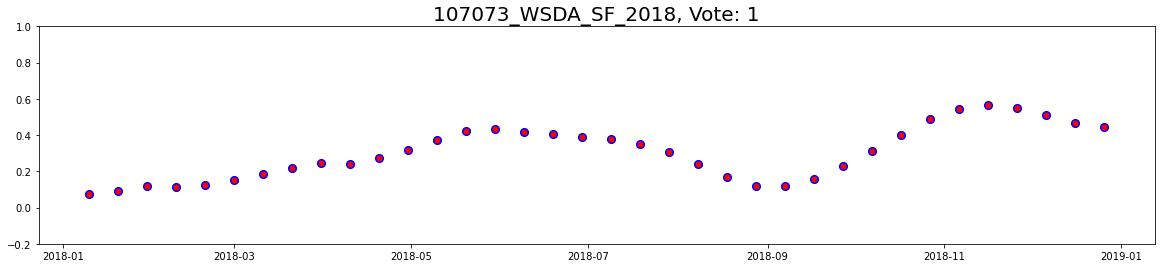

In [27]:
plt.figure(figsize=(20,4))
plt.subplot(1, 1, 1)

field_number = 120
ID = ground_truth.ID.unique()[field_number]
plt.scatter(ground_truth[ground_truth.ID==ID]["human_system_start_time"].values[:36],
            ground_truth[ground_truth.ID==ID][idx].values[:36],
            marker='o', s=65, c='b', label=idx);

plt.scatter(ground_truth[ground_truth.ID==ID]["human_system_start_time"].values[:36],
            ground_truth_wide[ground_truth_wide.ID==ID].values[0][1:],
            marker='o', s=25, c='r', label=idx);
plt.ylim([-0.2, 1])

vote = str(ground_truth_labels[ground_truth_labels.ID==ground_truth.ID.unique()[field_number]]['Vote'].values[0])
title = ground_truth.ID.unique()[field_number] + ", " + "Vote: " + vote
plt.title(title , fontsize = 20);

In [28]:
len(ground_truth_wide.ID.unique())==len(ground_truth_labels.ID.unique())

True

In [29]:
ground_truth.sort_values(by=["ID", 'human_system_start_time'], inplace=True)
ground_truth_labels.sort_values(by=["ID"], inplace=True)

ground_truth.reset_index(drop=True, inplace=True)
ground_truth_labels.reset_index(drop=True, inplace=True)

In [30]:
ground_truth.head(2)

,ID,human_system_start_time,EVI
0,100658_WSDA_SF_2017,2017-01-06,0.039378
1,100658_WSDA_SF_2017,2017-01-16,0.003539


In [31]:
ground_truth_labels.head(2)

,ID,Vote
0,100658_WSDA_SF_2017,2
1,100661_WSDA_SF_2017,1


In [32]:
# split the train and test set randomly
# split the train and test set randomly
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(ground_truth_wide, 
                                                                ground_truth_labels, 
                                                                test_size=0.2, 
                                                                random_state=0,
                                                                shuffle=True,
                                                                stratify=ground_truth_labels.Vote.values)

In [44]:
# Make an instance of the Model
# all parameters not specified are set to their defaults

# random_state is used for solver == ‘sag’, ‘saga’ or ‘liblinear’
logisticRegr = LogisticRegression(random_state=0); 
logisticRegr.fit(x_train_df.loc[:, "EVI_1":"EVI_36"], y_train_df.Vote.values);

prediction is [2].


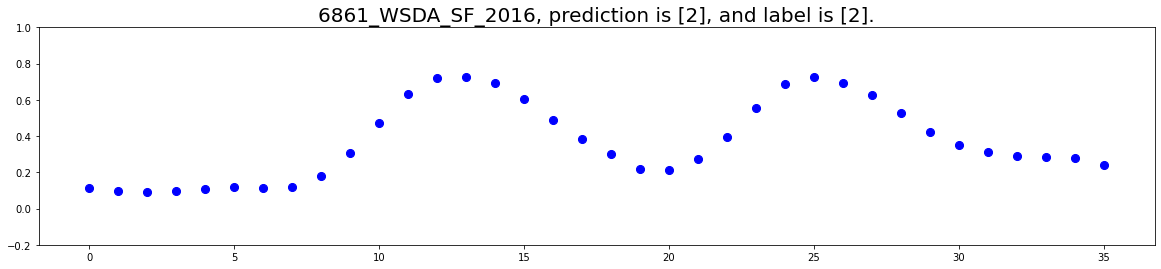

In [45]:
# Returns a NumPy Array
# Predict for One Observation (image)
test_index = 0
ID = x_test_df.iloc[test_index,].ID
prediction = logisticRegr.predict(x_test_df.iloc[test_index, 1:].values.reshape(1,-1))
print ("prediction is {}.".format(prediction))

######################################################
plt.figure(figsize=(20,4))
plt.subplot(1, 1, 1)

plt.scatter(range(len(x_test_df.iloc[test_index, 1:])),
            x_test_df.iloc[test_index, 1:].values,
            marker='o', s=65, c='b', label=idx);
plt.ylim([-0.2, 1])

curr_V = str(y_test_df[y_test_df.ID == ID].Vote.values[0])
title = ID + ", prediction is " + str(prediction) + ", and label is [" + curr_V + "]."
plt.title(title , fontsize = 20);

(-0.2, 1.0)

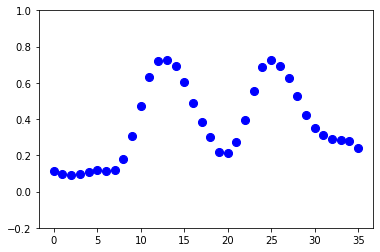

In [46]:
plt.scatter(range(len(x_test_df.iloc[test_index, 1:])),
            x_test_df.iloc[test_index, 1:].values,
            marker='o', s=65, c='b', label=idx);
plt.ylim([-0.2, 1])

In [47]:
confusion_table = pd.DataFrame(columns=['None', 'Predict_Single', 'Predict_Double'], index=range(2))
confusion_table.loc[0, 'None'] = 'Actual_Single'
confusion_table.loc[1, 'None'] = 'Actual_Double'
confusion_table['Predict_Single']=0
confusion_table['Predict_Double']=0

actual_double_predicted_single=[]

for idx in x_test_df.index:
    ID = x_test_df.loc[idx,].ID
    prediction = logisticRegr.predict(x_test_df.loc[idx, "EVI_1":].values.reshape(1,-1))
    prediction = prediction[0]
    curr_V = y_test_df[y_test_df.ID == ID].Vote.values[0]
    
    if prediction==curr_V==1:
        confusion_table.loc[0, "Predict_Single"]+=1
    elif prediction==curr_V==2:
        confusion_table.loc[1, "Predict_Double"]+=1
    
    elif prediction!=curr_V:
        if prediction==1:
            confusion_table.loc[1, "Predict_Single"]+=1
            actual_double_predicted_single += [ID]
        elif prediction==2:
            confusion_table.loc[0, "Predict_Double"]+=1
            


In [48]:
confusion_table

,None,Predict_Single,Predict_Double
0,Actual_Single,61,3
1,Actual_Double,11,12


In [49]:
actual_double_predicted_single

['110385_WSDA_SF_2018',
 '107541_WSDA_SF_2017',
 '53739_WSDA_SF_2016',
 '108279_WSDA_SF_2018',
 '1624_WSDA_SF_2016',
 '1236_WSDA_SF_2016',
 '53123_WSDA_SF_2016',
 '53718_WSDA_SF_2016',
 '108204_WSDA_SF_2018',
 '52028_WSDA_SF_2016',
 '60678_WSDA_SF_2016']

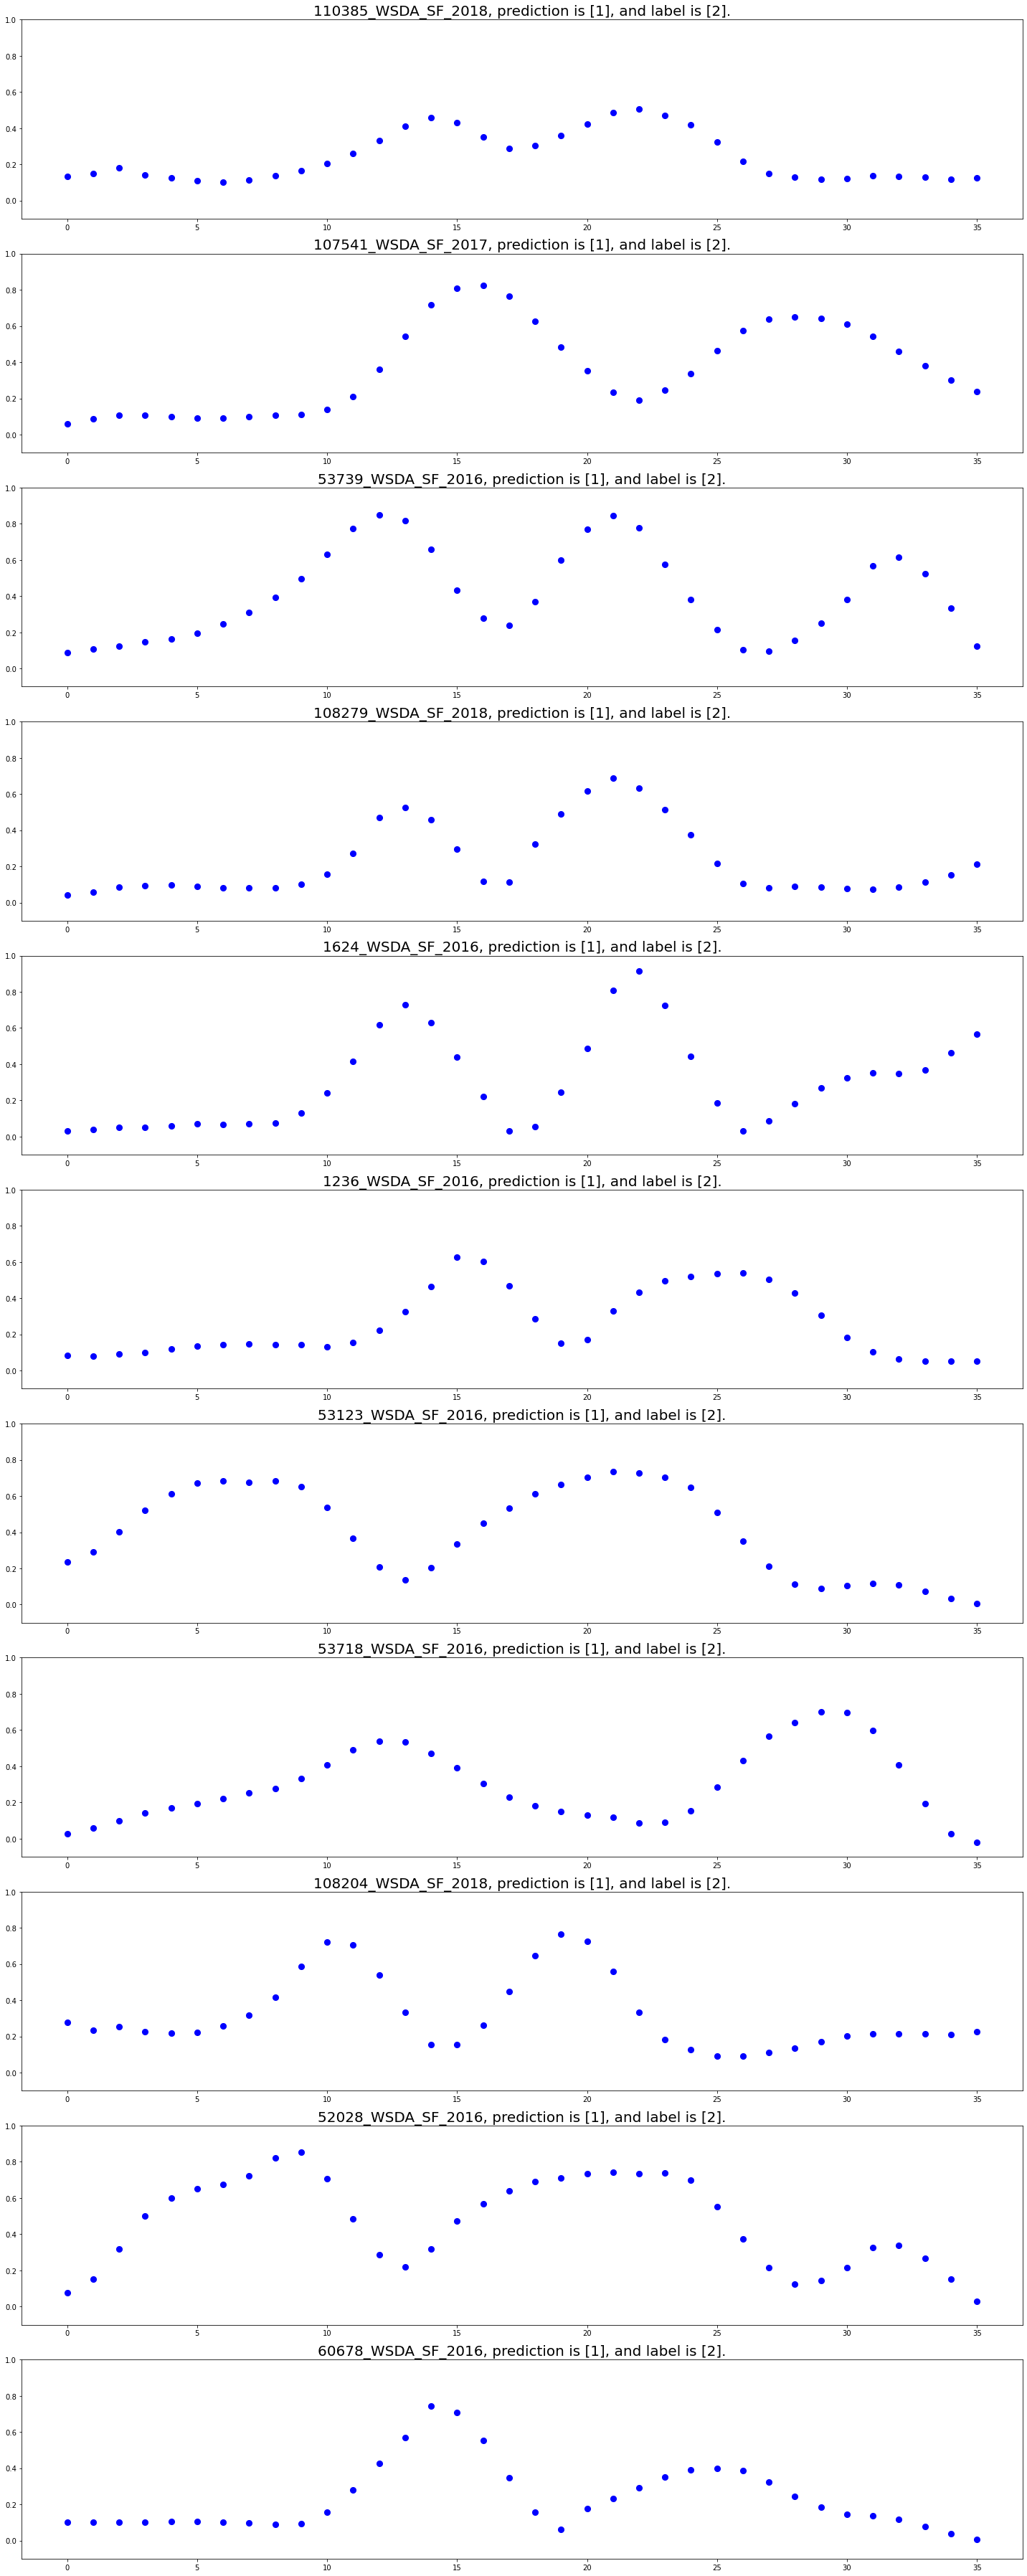

In [50]:
multiple_test_size = 11
plt.figure(figsize=(20, 50))
n_cols = 1
n_rows = multiple_test_size

for index in range(len(actual_double_predicted_single)):
    ID = actual_double_predicted_single[index]
    prediction = logisticRegr.predict(x_test_df[x_test_df.ID == ID].values[0][1:].reshape(1,-1))

    plt.subplot(n_rows, n_cols, index + 1) # 1 row, 5 columns, 
    plt.scatter(range(len(x_test_df[x_test_df.ID == ID].values[0][1:])),
                x_test_df[x_test_df.ID == ID].values[0][1:],
                marker='o', s=65, c='b', label=idx);
    plt.ylim([-0.1, 1])
    
    curr_V = str(y_test_df[y_test_df.ID == ID].Vote.values[0])
    title = ID + ", prediction is " + str(prediction) + ", and label is [" + curr_V + "]."
    plt.title(title , fontsize = 20);

plt.tight_layout()

# Confusion table for training set

In [51]:
confus_tbl_train = pd.DataFrame(columns=['None', 'Predict_Single', 'Predict_Double'], index=range(2))
confus_tbl_train.loc[0, 'None'] = 'Actual_Single'
confus_tbl_train.loc[1, 'None'] = 'Actual_Double'
confus_tbl_train['Predict_Single']=0
confus_tbl_train['Predict_Double']=0

actual_double_predicted_single=[]

for idx in x_train_df.index:
    ID = x_train_df.loc[idx,].ID
    prediction = logisticRegr.predict(x_train_df.loc[idx, "EVI_1":].values.reshape(1,-1))
    prediction = prediction[0]
    curr_V = y_train_df[y_train_df.ID == ID].Vote.values[0]
    
    if prediction==curr_V==1:
        confus_tbl_train.loc[0, "Predict_Single"]+=1
    elif prediction==curr_V==2:
        confus_tbl_train.loc[1, "Predict_Double"]+=1
    
    elif prediction!=curr_V:
        if prediction==1:
            confus_tbl_train.loc[1, "Predict_Single"]+=1
            actual_double_predicted_single += [ID]
        elif prediction==2:
            confus_tbl_train.loc[0, "Predict_Double"]+=1
            
confus_tbl_train

,None,Predict_Single,Predict_Double
0,Actual_Single,241,12
1,Actual_Double,30,64


In [67]:
30-12

18

# Horrible? on train set.
   - Use a larger train set and cross validation!
   - Diagnose
   - Tune parameters

In [53]:
# Make an instance of the Model
# all parameters not specified are set to their defaults

# random_state is used for solver == ‘sag’, ‘saga’ or ‘liblinear’
logisticRegr = LogisticRegression(random_state=0,
                                  class_weight="balanced");
logisticRegr.fit(x_train_df.loc[:, "EVI_1":"EVI_36"], y_train_df.Vote.values);

In [54]:
confus_tbl_train = pd.DataFrame(columns=['None', 'Predict_Single', 'Predict_Double'], index=range(2))
confus_tbl_train.loc[0, 'None'] = 'Actual_Single'
confus_tbl_train.loc[1, 'None'] = 'Actual_Double'
confus_tbl_train['Predict_Single']=0
confus_tbl_train['Predict_Double']=0

actual_double_predicted_single=[]

for idx in x_train_df.index:
    ID = x_train_df.loc[idx,].ID
    prediction = logisticRegr.predict(x_train_df.loc[idx, "EVI_1":].values.reshape(1,-1))
    prediction = prediction[0]
    curr_V = y_train_df[y_train_df.ID == ID].Vote.values[0]
    
    if prediction==curr_V==1:
        confus_tbl_train.loc[0, "Predict_Single"]+=1
    elif prediction==curr_V==2:
        confus_tbl_train.loc[1, "Predict_Double"]+=1
    
    elif prediction!=curr_V:
        if prediction==1:
            confus_tbl_train.loc[1, "Predict_Single"]+=1
            actual_double_predicted_single += [ID]
        elif prediction==2:
            confus_tbl_train.loc[0, "Predict_Double"]+=1
            
confus_tbl_train

,None,Predict_Single,Predict_Double
0,Actual_Single,207,46
1,Actual_Double,16,78


In [64]:
print((ground_truth_labels.Vote==1).sum()/(ground_truth_labels.Vote==2).sum())

2.7094017094017095


In [92]:
# Make an instance of the Model
# all parameters not specified are set to their defaults
from sklearn.linear_model import LogisticRegressionCV
logisticRegr_CV = LogisticRegressionCV(max_iter=100000, cv=10)
logisticRegr_CV.fit(ground_truth_wide.loc[:, "EVI_1":], ground_truth_labels.Vote.values)

LogisticRegressionCV(cv=116, max_iter=100000)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = load_digits(return_X_y=True)

title = "Learning Curves (Naive Bayes)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

title = r"Learning Curves"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, 
                    X=ground_truth_wide.loc[:, "EVI_1":], 
                    y=ground_truth_labels.Vote.values, 
                    axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

In [125]:
f_name = "/Users/hn/Documents/01_research_data/NASA/" +\
         "VI_TS/moreBands_train_set/" +\
         "L8_T1C2L2_Scaled_FranklinYakima2018_2018-01-01_2019-01-01.csv"
A = pd.read_csv(f_name)

In [126]:
A.head(2)

,ID,NDVI,EVI,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,system_start_time
0,108104_WSDA_SF_2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,101070_WSDA_SF_2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
L = len(A['SR_B2'].index[A['SR_B2'].apply(np.isnan)])

In [130]:
cc="SR_B3"
sum(A['SR_B2'].index[A['SR_B2'].apply(np.isnan)] == A[cc].index[A[cc].apply(np.isnan)])

ValueError: Lengths must match to compare

In [131]:
len(A['SR_B2'].index[A['SR_B2'].apply(np.isnan)])

3281147

In [132]:
len(A[cc].index[A[cc].apply(np.isnan)])

3281137

In [140]:
V = A['SR_B2'].index[A['SR_B2'].apply(np.isnan)].isin(A[cc].index[A[cc].apply(np.isnan)])

In [143]:
V = list(V)

In [145]:
V.index(False)

334116

In [147]:
A['SR_B2'].index[A['SR_B2'].apply(np.isnan)][334116]

336719

In [155]:
A.head(2)

,ID,NDVI,EVI,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,system_start_time
0,108104_WSDA_SF_2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,101070_WSDA_SF_2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [156]:
L8_dict = {"SR_B2":"blue",
           "SR_B3":"green",
           "SR_B4":"red",
           "SR_B5":"NIR",
           "SR_B6":"short_I_1",
           "SR_B7":"short_I_2",
           }

In [158]:
A.head(2)

,ID,NDVI,EVI,blue,green,red,NIR,short_I_1,short_I_2,system_start_time
0,108104_WSDA_SF_2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,101070_WSDA_SF_2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
